# FreeSolv Hydration Energy Prediction using Graph Neural Networks

### A comparative study of GCN vs GINE on molecular property regression

This notebook explores how graph neural networks can be used to predict
hydration free energy of small molecules from the FreeSolv dataset.

We compare:

-  Graph Convolutional Networks (GCN) : Using Node-features
- Edge-aware Graph Isomorphism Networks (GINE):For  Node  with Edge features(basically the entire graph).

we analyse their performance on a real-world chemistry dataset by MoleculeNET.

#Problem statement


## Predict the experimental hydration free energy of molecules using only their molecular graph structure.

Input:
- Molecular graph representation
- Node features (atom information)
- Edge features (bond information)

I followed this experimental pipeline:

1. Load FreeSolv dataset using PyTorch Geometric  
2. Visualise molecules using RDKit  
3. Create train/test split (80/20)  
4. Implement two models:

   - GCN: uses only node features  
   - GINE: uses node + edge features  

5. Train both models using identical settings(epochs etc.)  
6. Compare using standard regression metrics:

   - RMSE  
   - MAE  
   - R² Score  

In [1]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.1 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.datasets import MoleculeNet
import matplotlib.pyplot as plt

In [3]:
!python --version

Python 3.12.12


In [4]:
! pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 46.6 MB/s eta 0:00:00


# Dataset Description

The FreeSolv dataset contains:

- 642 small molecules
- Experimental hydration free energies
- SMILES representations
- Precomputed molecular graph features


In [5]:
data = MoleculeNet(root='data', name='FreeSolv')

Processing...
Done!


Each molecule is represented as:

- Nodes → atoms with 9 features
- Edges → bonds with 3 features
- Target → single real-valued energy

This dataset is small, making it challenging and prone to overfitting.

In [6]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)


Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  485
Dataset length:  <bound method InMemoryDataset.len of FreeSolv(642)>
Dataset sample:  Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])
Sample  nodes:  13
Sample  edges:  26


/usr/local/lib/python3.12/dist-packages/torch_geometric/data/in_memory_dataset.py:91: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  return self._infer_num_classes(self._data.y)


# Exploratory Data Analysis (EDA)

Before training any model, it was important to understand the dataset
and the kind of information it contains.



### Observations from Target Analysis

From the distribution plot, we observed:

- The target values are roughly centred around a negative mean  
- Distribution is not perfectly Gaussian  
- No extreme outliers were detected  
- Values fall within a reasonable numeric range

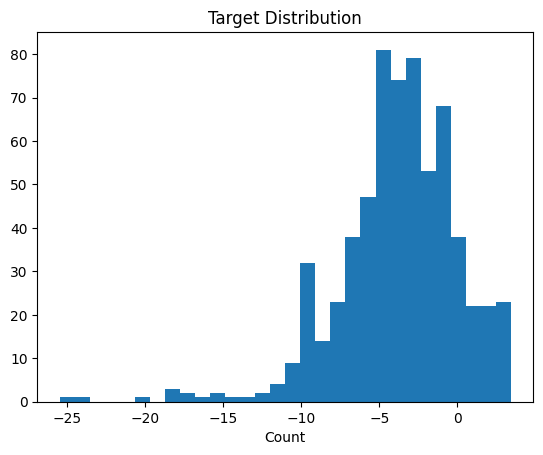

In [7]:
ys = [i.y.item() for i in data]

plt.hist(ys,bins=30)
plt.title("Target Distribution")
plt.xlabel("Solubility Value")
plt.xlabel("Count")
plt.show()

## Visualising Molecules from SMILES

To better understand what kind of molecules we are working with,
we used **RDKit** to convert SMILES strings into visual molecular diagrams.

- There are diverse molecular shapes and sizes  


In [8]:
from rdkit import Chem
from rdkit.Chem import Draw

In [9]:
smiles_list = [i.smiles for i in data[:6]]

mols = [Chem.MolFromSmiles(s) for s in smiles_list]

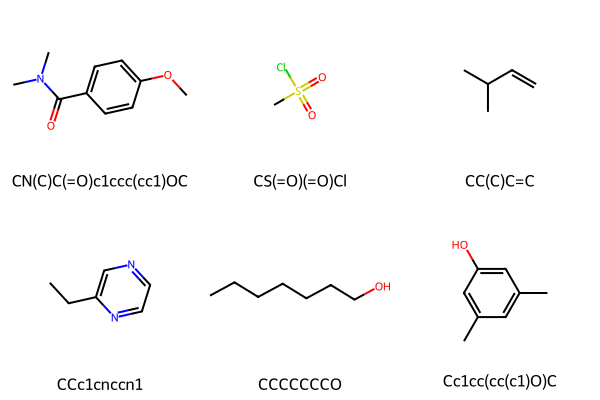

In [10]:
Draw.MolsToGridImage(mols, molsPerRow=3, legends=smiles_list)

In [11]:
sample = data[0]

print("SMILES:", sample.smiles)
print("Node feature matrix shape:", sample.x.shape)
print("Edge index shape:", sample.edge_index.shape)
print("Edge feature shape:", sample.edge_attr.shape)
print("Target value:", sample.y.item())


SMILES: CN(C)C(=O)c1ccc(cc1)OC
Node feature matrix shape: torch.Size([13, 9])
Edge index shape: torch.Size([2, 26])
Edge feature shape: torch.Size([26, 3])
Target value: -11.010000228881836


## Adjaceny Matrix (but a different format)


This format of representing is more optimal and easier , instead of creating an NxN adjaceny matrix to show the nodes and the connected nodes.

-This saves memory
-Readable format

In [123]:
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 2,  1],
        [ 3,  1],
        [ 3,  4],
        [ 3,  5],
        [ 4,  3],
        [ 5,  3],
        [ 5,  6],
        [ 5, 10],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 8,  9],
        [ 8, 11],
        [ 9,  8],
        [ 9, 10],
        [10,  5],
        [10,  9],
        [11,  8],
        [11, 12],
        [12, 11]])

Drawing a molecule using a simple fucntion, to fetch a molecule with index refrence

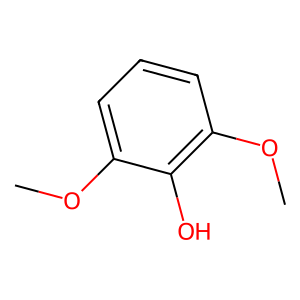

In [124]:
def show_molecule(idx):
    s = data[idx].smiles
    mol = Chem.MolFromSmiles(s)
    return Draw.MolToImage(mol)

show_molecule(53)


# MODEL 1: Graph Convolution Network

## What Are Graph Convolutional Networks?
Graph Convolutional Networks (GCNs) are a type of neural network designed to work directly with graphs.
- A graph consists of nodes (vertices) and edges (connections between nodes).

- In a GCN, each node represents an entity, and the edges represent the relationships between these entities.

- The primary goal of GCNs is to learn node embeddings, which are vector representations of nodes that capture the graph's structural and feature information.

## Model Architecture of GCN(1-layer)

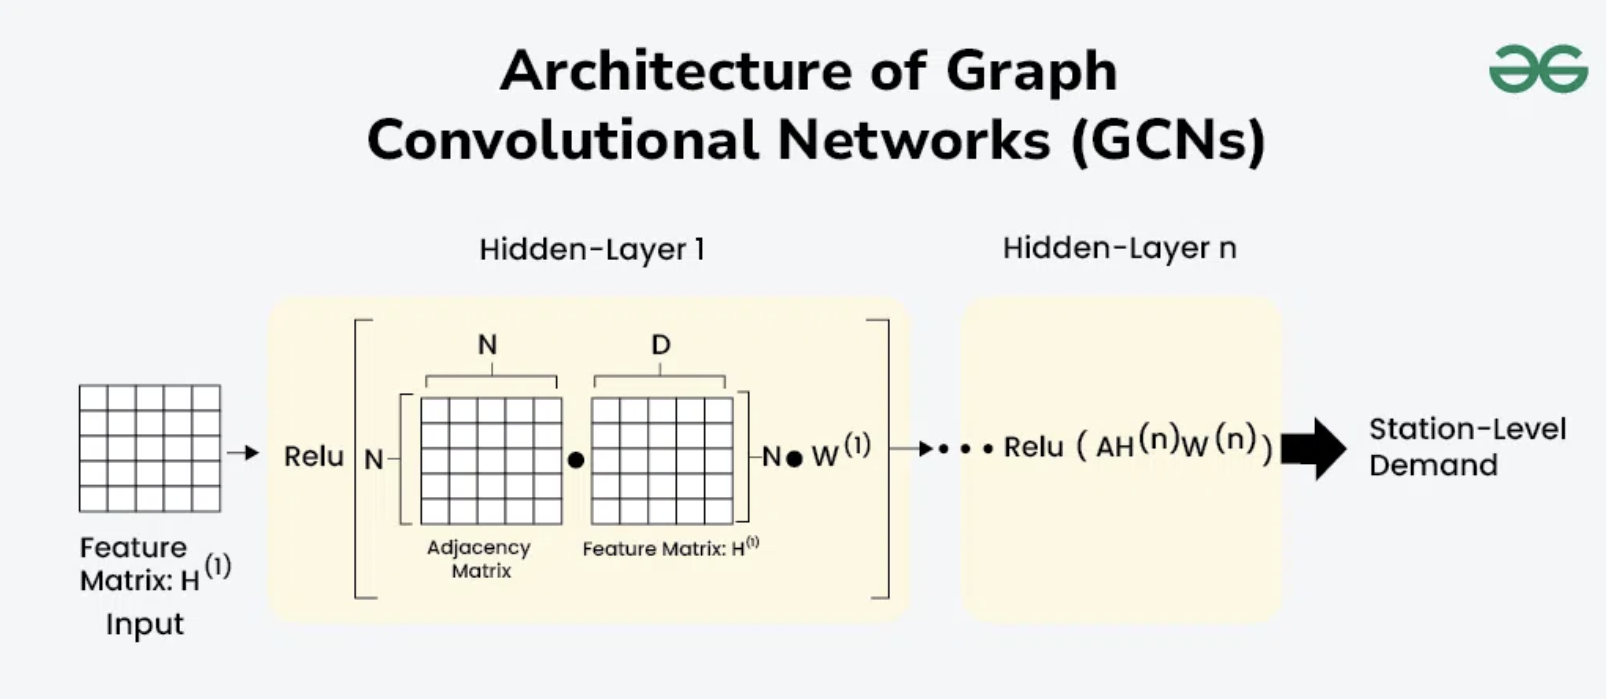

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv,global_mean_pool, global_max_pool
from torch_geometric.loader import DataLoader

In [91]:
embedding_size=64

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.conv1=GCNConv(data.num_features,embedding_size)
        self.conv2=GCNConv(embedding_size,embedding_size)
        self.conv3= GCNConv(embedding_size, embedding_size)

        self.out = Linear(embedding_size *2,1)

    def forward(self,x, edge_index, batch_index):



        x=self.conv1(x,edge_index)
        x= F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x=self.conv2(x,edge_index)
        x= F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x=self.conv3(x,edge_index)
        x= F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = torch.cat([
         global_mean_pool(x, batch_index),
         global_max_pool(x, batch_index)
        ], dim=1)


        out = self.out(x)

        return out,x


In [92]:
dataset = data.shuffle()

train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size

train_dataset = dataset[:train_size]
test_dataset  = dataset[train_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [93]:
model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  9089


### Key Design Choices

Embedding size = 64 → balanced capacity for small dataset

3 GCN layers → captures up to 3-hop neighbourhood information

Dropout = 0.3 after each layer → reduce overfitting

Pooling strategy:

global_mean_pool + global_max_pool

Concatenated to form 128-dim graph embedding

Final Linear layer maps graph embedding → regression output

In [94]:
# Loss and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [95]:
def train():
    model.train()

    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()

        # Forward pass
        pred, embedding = model(batch.x.float(),
                                batch.edge_index,
                                batch.batch)

        # Compute loss (flatten to avoid shape mismatch)
        loss = loss_fn(pred.view(-1), batch.y.view(-1))

        loss.backward()
        optimizer.step()

    return loss, embedding


In [96]:
def test():
    model.eval()
    total_loss = 0

    for batch in test_loader:
        batch = batch.to(device)

        pred, _ = model(batch.x.float(),
                        batch.edge_index,
                        batch.batch)

        loss = loss_fn(pred.view(-1), batch.y.view(-1))
        total_loss += loss.item()

    return total_loss / len(test_loader)


In [97]:
train_losses = []
test_losses = []

for epoch in range(500):

    loss, h = train()
    train_losses.append(loss.item())

    test_loss = test()
    test_losses.append(test_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch 0 | Train Loss: 18.6018 | Test Loss: 9.9529
Epoch 50 | Train Loss: 3.7053 | Test Loss: 5.4707
Epoch 100 | Train Loss: 7.9402 | Test Loss: 4.8382
Epoch 150 | Train Loss: 7.9171 | Test Loss: 4.2600
Epoch 200 | Train Loss: 32.6950 | Test Loss: 3.6519
Epoch 250 | Train Loss: 0.2728 | Test Loss: 2.9597
Epoch 300 | Train Loss: 3.1766 | Test Loss: 2.8980
Epoch 350 | Train Loss: 2.6476 | Test Loss: 2.8363
Epoch 400 | Train Loss: 0.6207 | Test Loss: 3.1953
Epoch 450 | Train Loss: 5.7098 | Test Loss: 4.1609


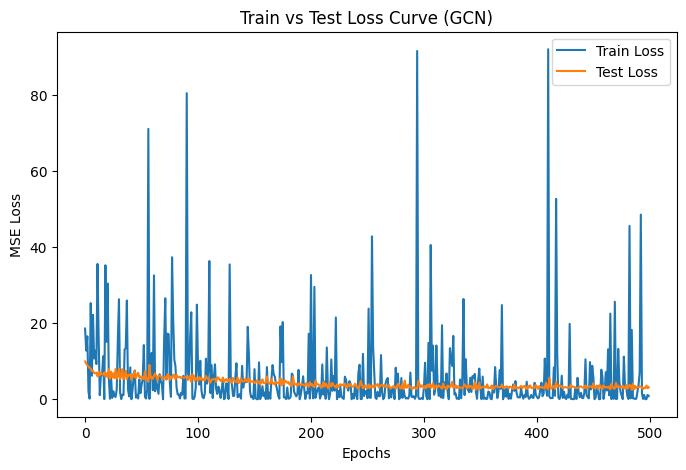

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

indices = list(range(len(train_losses)))

plt.figure(figsize=(8,5))

sns.lineplot(x=indices, y=train_losses, label="Train Loss")
sns.lineplot(x=indices, y=test_losses, label="Test Loss")

plt.title("Train vs Test Loss Curve (GCN)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

plt.legend()
plt.show()


In [99]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

model.eval()

all_preds = []
all_true  = []

for batch in test_loader:
    batch = batch.to(device)

    pred, _ = model(batch.x.float(),
                    batch.edge_index,
                    batch.batch)

    all_preds.append(pred.detach().cpu().numpy())
    all_true.append(batch.y.detach().cpu().numpy())

preds = np.concatenate(all_preds)
true  = np.concatenate(all_true)

rmse = np.sqrt(np.mean((preds - true) ** 2))
mae  = mean_absolute_error(true, preds)
r2   = r2_score(true, preds)

print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)


RMSE: 1.9595038
MAE : 1.4459588527679443
R2  : 0.5805984735488892


/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


In [100]:
import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,2.83,1.949241
1,-4.77,-2.988355
2,-5.53,-2.915411
3,-3.88,-2.841575
4,-4.55,-2.711395
5,-4.16,-0.911383
6,-4.42,-4.942055
7,-3.48,-1.604237
8,-3.58,-3.521751
9,-4.45,-2.800855


<Axes: xlabel='y_real', ylabel='y_pred'>

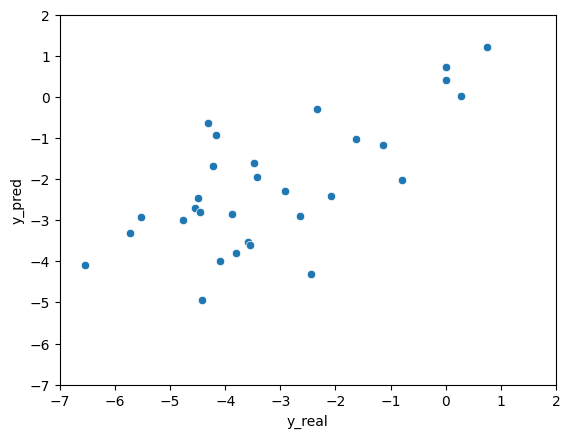

In [122]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

## Observation:

After training the GCN model for 500 epochs:

Performance Metrics:

- RMSE: 1.9595

- MAE: 1.4459

- R² Score: 0.5806

Interpretation

- The model was able to learn meaningful patterns from node features alone

However, performance is limited due to:
- small dataset

- Lack of edge feature usage

- Simpler aggregation mechanism

# Model 2 : GINE: Graph Isomorphism Network with Edge features.

### What is GINE?

GINE is an extension of GIN (Graph Isomorphism Network)
Designed specifically to handle both node AND edge features.

More expressive than standard GCN/GAT.

Very suitable for molecular graphs where bonds carry important information.

## Working of GINE –

For each node in the graph:

- Take the node feature vector

- Collect neighbouring node features

- Also collect corresponding edge (bond) features

- Combine neighbour node features with their edge features

- Pass this combined information through an MLP (multi-layer perceptron)

- Aggregate results from all neighbours (sum aggregation)

- Add learnable epsilon-weighted self-feature

- Produce updated node embedding

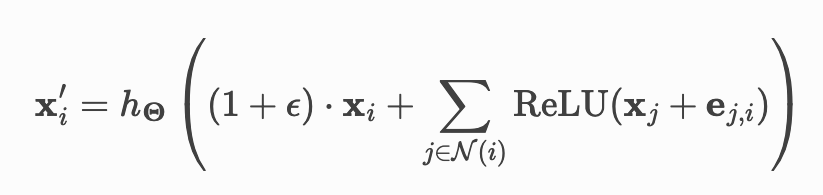

In [102]:
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from torch_geometric.nn import GINEConv, global_add_pool

In [114]:
class GINEModel(torch.nn.Module):
    def __init__(self, node_features, edge_features, hidden_channels):
        super(GINEModel, self).__init__()

        def create_mlp(in_dims, out_dims):
            return Sequential(
                Linear(in_dims, out_dims),
                torch.nn.LeakyReLU(),
                torch.nn.Dropout(0.3),
                Linear(out_dims, out_dims)
            )


        self.edge_embedding = Linear(edge_features, hidden_channels)

        self.conv1 = GINEConv(
            create_mlp(node_features, hidden_channels),
            edge_dim=hidden_channels
        )

        self.conv2 = GINEConv(
            create_mlp(hidden_channels, hidden_channels),
            edge_dim=hidden_channels
        )

        self.out = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):

        # Project edge features first
        edge_attr = self.edge_embedding(edge_attr)

        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)

        x = global_add_pool(x, batch)

        return self.out(x)


In [115]:
# Device first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create GINE model
model_2 = GINEModel(node_features=9, edge_features=3, hidden_channels=32)
model_2 = model_2.to(device)

print(model_2)

print("Number of parameters: ", sum(p.numel() for p in model_2.parameters()))

# Loss and optimizer (attached to model_2)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0007)


GINEModel(
  (edge_embedding): Linear(in_features=3, out_features=32, bias=True)
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  ))
  (conv2): GINEConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  ))
  (out): Linear(in_features=32, out_features=1, bias=True)
)
Number of parameters:  5002


## Key Architectural Points

Uses GINEConv layers which explicitly incorporate edge (bond) features along with node features

- Each GINE layer contains an internal MLP to learn complex node–edge interactions

- Edge features are first projected using a Linear edge embedding layer

- Two GINEConv layers are used with hidden dimension = 32

- LeakyReLU activation and Dropout (0.3) added after each layer for regularisation

- Graph-level representation obtained using global add pooling

- Final prediction produced by a Linear output layer

In [116]:
def train_2():
    model_2.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass (GINE requires edge_attr)
        pred = model_2(batch.x.float(),
                       batch.edge_index,
                       batch.edge_attr.float(),
                       batch.batch)

        loss = loss_fn(pred.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


In [117]:
def test_2():
    model_2.eval()
    total_loss = 0

    with torch.no_grad():  # Good practice to save memory
        for batch in test_loader:
            batch = batch.to(device)

            # Forward pass with edge features
            pred = model_2(batch.x.float(),
                           batch.edge_index,
                           batch.edge_attr.float(),
                           batch.batch)

            loss = loss_fn(pred.view(-1), batch.y.view(-1))
            total_loss += loss.item()

    return total_loss / len(test_loader)


In [118]:
train_losses_2 = []
test_losses_2 = []

for epoch in range(500):


    loss_val = train_2()
    t_loss = test_2()

    train_losses_2.append(loss_val)
    test_losses_2.append(t_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {loss_val:.4f} | Test Loss: {t_loss:.4f}")


Epoch 000 | Train Loss: 18.9276 | Test Loss: 7.8903
Epoch 050 | Train Loss: 11.9749 | Test Loss: 6.3162
Epoch 100 | Train Loss: 8.8880 | Test Loss: 5.8764
Epoch 150 | Train Loss: 7.2128 | Test Loss: 4.6373
Epoch 200 | Train Loss: 5.0350 | Test Loss: 3.3559
Epoch 250 | Train Loss: 4.4943 | Test Loss: 3.2278
Epoch 300 | Train Loss: 5.9362 | Test Loss: 4.0196
Epoch 350 | Train Loss: 3.2920 | Test Loss: 2.5685
Epoch 400 | Train Loss: 4.5869 | Test Loss: 2.2677
Epoch 450 | Train Loss: 2.9605 | Test Loss: 2.3341


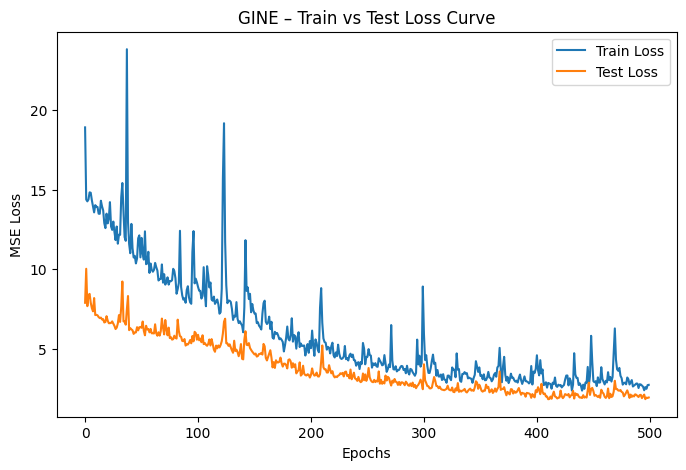

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

epochs = list(range(len(train_losses_2)))

plt.figure(figsize=(8,5))

sns.lineplot(x=epochs, y=train_losses_2, label="Train Loss")
sns.lineplot(x=epochs, y=test_losses_2, label="Test Loss")

plt.title("GINE – Train vs Test Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

plt.show()


In [120]:
model_2.eval()
all_preds = []
all_true  = []

for batch in test_loader:
    batch = batch.to(device)

    # Forward pass with edge_attr
    pred = model_2(batch.x.float(),
                   batch.edge_index,
                   batch.edge_attr.float(),
                   batch.batch)

    all_preds.append(pred.detach().cpu().numpy())
    all_true.append(batch.y.detach().cpu().numpy())

# Flatten everything into 1D arrays
preds_2 = np.concatenate(all_preds).flatten()
true_2  = np.concatenate(all_true).flatten()

# Metrics
rmse = np.sqrt(np.mean((preds_2 - true_2) ** 2))
mae  = mean_absolute_error(true, preds)
r2   = r2_score(true_2, preds_2)

print(" Final GINE Performance ")
print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)


 Final GINE Performance 
RMSE: 1.5461329
MAE : 1.4459588527679443
R2  : 0.738885223865509


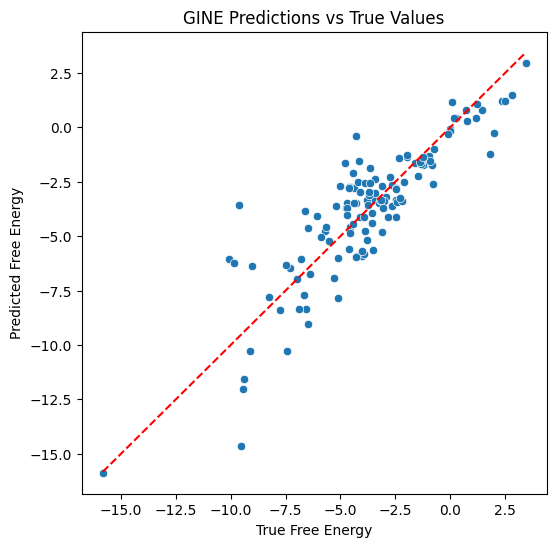

In [121]:
plt.figure(figsize=(6,6))

sns.scatterplot(x=true_2, y=preds_2)

plt.title("GINE Predictions vs True Values")
plt.xlabel("True Free Energy")
plt.ylabel("Predicted Free Energy")

# Perfect prediction reference line
plt.plot([min(true), max(true)],
         [min(true), max(true)],
         color="red", linestyle="--")

plt.show()


## Observation

RMSE: ~1.54

MAE: ~1.44

R² Score: ~0.73

These values indicate strong predictive performance and good generalisation on unseen data,given a small dataset.



- **GINE **significantly outperformed** GCN** because it can utilise both node and edge features

- Explicit modelling of bond information improved learning

- Lower parameter count (5k) helped reduce overfitting




# Conclusion

In this experiment, two Graph Neural Network models were implemented to predict molecular properties: GCN and GINE.







**GCN**  was able to learn reasonable patterns using only node features, but its inability to incorporate edge (bond) information limited its performance.

- RMSE: 1.959
- MAE : 1.445
- R^2  : 0.580

**GINE**, on the other hand, explicitly models both node and *edge features through specialised convolution layers with internal MLPs.* This allowed the model to capture richer chemical relationships within molecules, leading to **significantly better predictive accuracy with fewer parameters.**

 Final GINE Performance
- RMSE: 1.54
- MAE : 1.445
- R2  : 0.738

After tuning and controlling overfitting through dropout and optimal epochs, GINE emerged as the more suitable architecture for molecular regression tasks, achieving higher R² and lower error metrics.


Therefore, for g**raph datasets where edge attributes carry important information**, **GINEConv-based** models are clearly preferable over standard **GCN.**